In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import deconomix
from tqdm import tqdm

In [2]:
test, train = deconomix.utils.load_example()

# Prepare Test Data
# For each cell type (column), randomly select 50 genes and apply a random regulation factor (between 0.1 and 10)

test_regulated = test.copy()
np.random.seed(42)  # For reproducibility

for celltype in test_regulated.columns.unique():
    genes = test_regulated.index
    selected_genes = np.random.choice(genes, size=200, replace=False)
    regulation_factors = np.random.uniform(0.1, 10, size=200)
    test_regulated.loc[selected_genes, celltype] = (
        test_regulated.loc[selected_genes, celltype].values * regulation_factors[:, np.newaxis]
    )




Raw data already downloaded
Importing Data to Python ...
Using cached, preprocessed data
Done


In [3]:
print(test.size)
print(test.size - (test==test_regulated).sum().sum())

884000
47799


In [4]:
X_ref, Y_mat, C_mat = deconomix.utils.simulate_data(train, n_mixtures = 1000, n_cells_in_mix = 100)
_, Y_test, C_test = deconomix.utils.simulate_data(test_regulated, n_mixtures = 1000, n_cells_in_mix = 100)
model0 = deconomix.methods.DTD(X_ref, Y_mat, C_mat)
model0.run(iterations = 300)

i = 300, loss = -5.824858e+00: 100%|██████████| 300/300 [00:02<00:00, 146.82it/s]


In [5]:
#model_HPS_gamma_ones =  deconomix.hps.HPS(X_ref,
#                                          Y_test)

In [6]:
#model_HPS_gamma_ones.run(n_workers=50)

In [7]:
#model_HPS_gamma_ones.results.to_pickle("HPS_results_Tirosh.pkl")

In [8]:
results = pd.read_pickle("HPS_results_Tirosh.pkl")

In [16]:
results

loss              
                      mean           std
lambda                                  
1.000000e-20  2.346841e+06  19669.679723
1.000000e-19  2.346841e+06  19669.679582
1.000000e-18  2.346841e+06  19669.678181
1.000000e-17  2.346841e+06  19669.663666
1.000000e-16  2.346840e+06  19669.493342
1.000000e-15  2.357400e+06  28766.793321
1.000000e-14  2.351453e+06  29519.476351
1.000000e-13  2.361830e+06  22139.030174
1.000000e-12  2.360666e+06  20802.118638
1.000000e-11  2.355232e+06  22875.629179
1.000000e-10  2.339781e+06  16862.772113
1.000000e-09  2.298432e+06  16131.818883
1.000000e-08  2.221238e+06  12878.374815
1.000000e-07  2.179498e+06  10724.860297
1.000000e-06  2.205129e+06  10239.094106
1.000000e-05  2.256053e+06  10015.886490
1.000000e-04  2.268719e+06   9983.880790
1.000000e-03  2.270216e+06   9980.425946
1.000000e-02  2.270369e+06   9980.076496
1.000000e-01  2.270384e+06   9980.041516
1.000000e+00  2.270386e+06   9980.038017

In [17]:
# Set global style parameters
plt.rcParams.update({
    'font.size': 14,                 # Global font size
    'axes.titlesize': 16,            # Title font size
    'axes.labelsize': 14,            # Axis label font size
    'xtick.labelsize': 12,           # X-tick label font size
    'ytick.labelsize': 12,           # Y-tick label font size
    'legend.fontsize': 12,           # Legend font size
    'figure.figsize': (5, 4),        # Figure size
    'axes.linewidth': 1.2,           # Line width for axes
    'grid.linewidth': 0.5,           # Line width for grid lines
    'grid.color': 'gray',            # Grid line color
    'legend.frameon': True,         # No frame for legend
    'axes.grid': False,               # Enable grid
    'grid.alpha': 0.5,
    'savefig.bbox' : 'tight',
    'savefig.pad_inches' : 0.05,
    'font.family' : 'sans-serif',
    'mathtext.fontset' : 'dejavusans'})

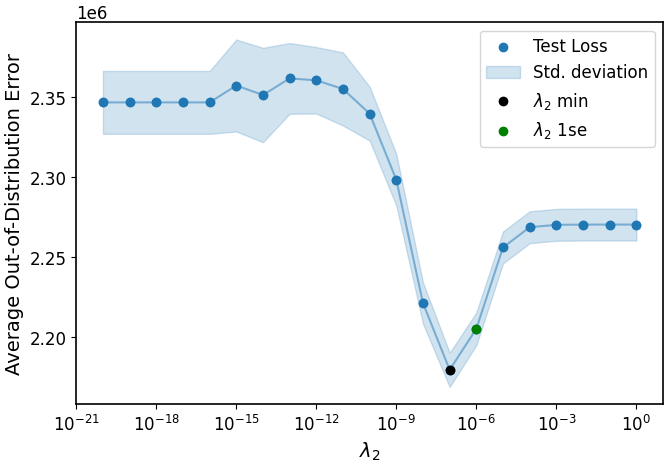

In [18]:
deconomix.hps.plot_results(results)

In [19]:
results

loss              
                      mean           std
lambda                                  
1.000000e-20  2.346841e+06  19669.679723
1.000000e-19  2.346841e+06  19669.679582
1.000000e-18  2.346841e+06  19669.678181
1.000000e-17  2.346841e+06  19669.663666
1.000000e-16  2.346840e+06  19669.493342
1.000000e-15  2.357400e+06  28766.793321
1.000000e-14  2.351453e+06  29519.476351
1.000000e-13  2.361830e+06  22139.030174
1.000000e-12  2.360666e+06  20802.118638
1.000000e-11  2.355232e+06  22875.629179
1.000000e-10  2.339781e+06  16862.772113
1.000000e-09  2.298432e+06  16131.818883
1.000000e-08  2.221238e+06  12878.374815
1.000000e-07  2.179498e+06  10724.860297
1.000000e-06  2.205129e+06  10239.094106
1.000000e-05  2.256053e+06  10015.886490
1.000000e-04  2.268719e+06   9983.880790
1.000000e-03  2.270216e+06   9980.425946
1.000000e-02  2.270369e+06   9980.076496
1.000000e-01  2.270384e+06   9980.041516
1.000000e+00  2.270386e+06   9980.038017

In [20]:
deconomix.hps.get_lambda_min(results)

np.float64(1e-07)

<Figure size 500x400 with 0 Axes>

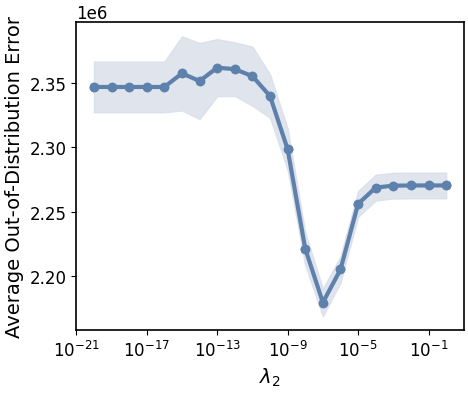

In [22]:
plt.figure()
lambdas = np.array(results.index, dtype=float)
loss_raw_mean = results[('loss', 'mean')].values
loss_raw_std = results[('loss', 'std')].values

# Plot with filled error region
fig, ax = plt.subplots(figsize=(5, 4))



ax.plot(lambdas, loss_raw_mean, marker='o', c="#5e81ac", linestyle='-', alpha=1, lw=3)
ax.scatter(lambdas, loss_raw_mean, label='Test Loss', marker='o', alpha=1)
# Fill between mean - std and mean + std for shaded error region
ax.fill_between(lambdas, 
                loss_raw_mean - loss_raw_std, 
                loss_raw_mean + loss_raw_std, 
                color="#d8dee9", alpha=0.8, label='Std. deviation')

#ax.legend()

ax.set_xscale('log')
ax.set_xlabel('$\\lambda_2$')
ax.set_ylabel('Average Out-of-Distribution Error')
plt.savefig("plots_appnote/pdf/HPS_loss_raw.pdf")
plt.savefig("plots_appnote/png/HPS_loss_raw.png",dpi=600)

In [23]:
deconomix.hps.get_lambda_1se(results)

np.float64(1e-06)

In [ ]:
#model_ADTD = deconomix.methods.ADTD(X_ref, Y_test, model0.gamma, Delta_static=False, C_static=True, lambda2=1e-06, max_iterations=1000)

In [ ]:
#model_ADTD.run()

i = 15, err = 1.76e-05, loss = 1.369568e-02, loss RSS = 1.314469e-02, loss bias = 5.509886e-04:   2%|▏         | 15/1000 [00:12<13:41,  1.20it/s]


KeyboardInterrupt: 

In [ ]:
model_ADTD.Delta_est.to_pickle("Delta_est2.pkl")